<a href="https://colab.research.google.com/github/kurianbenoy/Tensorflow-2.0-notebooks/blob/master/petal2metal_flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

Welcome to Petals to Metal: Flower Competition, here are you are challenged to build a deep learning model for classifying flowers

![images.jpeg](attachment:images.jpeg)



### Table of contents

1. [What are Tensor Processing Units?](#tpu)
2. [Peeking into TPU Hardware](#peek) 
3. [Exploring flowers](#eda) 
4. [What's EfficentNet](#efficentnet)
5. [Densenet](#densenet)
5. [Final model submission](#submit)

# What are TPU's? <a class="tpu" id="prepare"></a>



TPU's are holy grail of computers for any Machine Learning Practitioners! A tensor processing unit (TPU) is an AI accelerator application-specific integrated circuit (ASIC) developed by Google specifically for neural network machine learning. 
TPUs are hardware accelerators specialized in deep learning tasks. In this code lab, you will see how to use them with Keras and Tensorflow 2. Cloud TPUs are available in a base configuration with 8 cores and also in larger configurations called "TPU pods" of up to 2048 cores. The extra hardware can be used to accelerate training by increasing the training batch size.


## Why TPUs?

Modern GPUs are organized around programmable "cores", a very flexible architecture that allows them to handle a variety of tasks such as 3D rendering, deep learning, physical simulations, etc.. TPUs on the other hand pair a classic vector processor with a dedicated matrix multiply unit and excel at any task where large matrix multiplications dominate, such as neural networks.


<html>
<body>

<p><font size="4" color="Blue"> The following video from Kaggle explains the main components of TPU like systolic arrays and bfloat16 number formats, and how these two components of TPUs help reduce deep learning model training times </font></p>
</body>
</html>

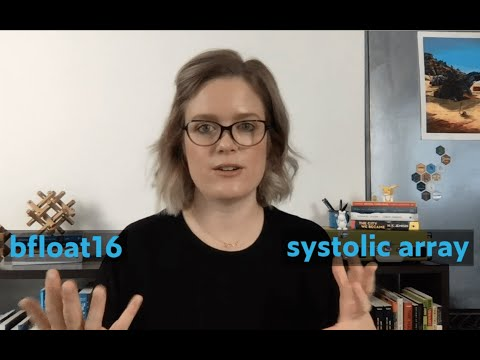

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo("JC84GCU7zqA")

# Peeking into TPU Hardware [source](https://codelabs.developers.google.com/codelabs/keras-flowers-tpu/#2)<a class="anchor" id="peek"></a>



## MXU and VPU


A TPU v3 core is made of a Matrix Multiply Unit (MXU) which runs matrix multiplications and a Vector Processing Unit (VPU) for all other tasks such as activations, softmax, etc. The VPU handles float32 and int32 computations. The MXU on the other hand operates in a mixed precision 16-32 bit floating point format. The give image below shows a TPUv3 which operates at 420 TeraFlops and 128 GB HBM.

![Screenshot_2020-02-26%20Keras%20and%20modern%20convnets,%20on%20TPUs.png](attachment:Screenshot_2020-02-26%20Keras%20and%20modern%20convnets,%20on%20TPUs.png)

## Mixed precision floating point and bfloat16

The MXU computes matrix multiplications using bfloat16 inputs and float32 outputs. Intermediate accumulations are performed in float32 precision.

Neural network training is typically resistant to the noise introduced by a reduced floating point precision. There are cases where noise even helps the optimizer converge. 16-bit floating point precision has traditionally been used to accelerate computations but float16 and float32 formats have very different ranges. Reducing the precision from float32 to float16 usually results in over and underflows. Solutions exist but additional work is typically required to make float16 work.

That is why Google introduced the bfloat16 format in TPUs. bfloat16 is a truncated float32 with exactly the same exponent bits and range as float32. This, added to the fact that TPUs compute matrix multiplications in mixed precision with bfloat16 inputs but float32 outputs, means that, typically, no code changes are necessary to benefit from the performance gains of reduced precision.


> The use of bfloat16/float32 mixed precision is the default on TPUs. No code changes are necessary in your Tensorflow code to enable it

## Systolic arrays

CPUs are made to run pretty much any calculation. Therefore, CPU store values in registers and a program sends a set of instructions to the Arithmetic Logic Unit to read a given register, perform an operation and register the output into the right register. This comes at some cost in terms of power and chip area.

For an MXU, matrix multiplication reuses both inputs many times, 



## Under the hood: XLA

Tensorflow programs define computation graphs. The TPU does not directly run Python code, it runs the computation graph defined by your Tensorflow program. Under the hood, a compiler called XLA (accelerated Linear Algebra compiler) transforms the Tensorflow graph of computation nodes into TPU machine code. This compiler also performs many advanced optimizations on your code and your memory layout. The compilation happens automatically as work is sent to the TPU. You do not have to include XLA in your build chain explicitly.


## Using TPUs in Keras

TPUs are supported through the Keras API as of Tensorflow 2.1. Keras support works on TPUs and TPU pods.

Don't worry TPU is also supported in Pytorch, check out @abhishek, 4X Kaggle grandmaster's video on [training BERT's in TPU](https://www.youtube.com/watch?v=s-3zts7FTDA)


[Do check out System Architecture of TPU](https://cloud.google.com/tpu/docs/system-architecture) gives more detials of TPU configurations and various versions of TPU 

<html>
<body>

<p><font size="4" color="Blue"> This video explains in detail about main differences between TPUv2 and TPUv3 </font></p>
</body>
</html>



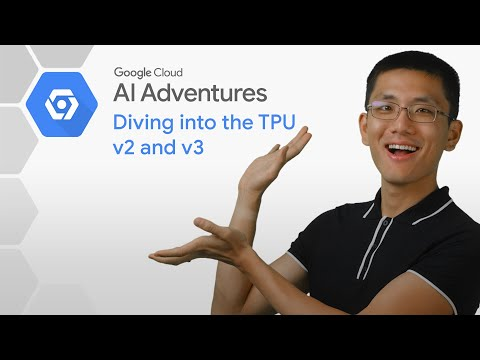

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("kBjYK3K3P6M")

## Importing library

In [1]:
!pip install  efficientnet

import efficientnet.tfkeras as efn
import re
import math
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.metrics import TruePositives, FalsePositives, FalseNegatives
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.2.0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Dataset Processing

In [33]:
GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec'
IMAGE_SIZE = [192, 192]

BATCH_SIZE = 64 # 128 works on GPU too but comes very close to the memory limit of the Colab GPU
EPOCHS = 5

VALIDATION_SPLIT = 0.2
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # do not change, maps to the labels in the data (folder names)

# splitting data files between training and validation
filenames = tf.io.gfile.glob(GCS_PATTERN)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
validation_steps = int(3670 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(3670 // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 64, there will be 46 batches per training epoch and 10 batch(es) per validation run.


In [2]:
# This is basically -1
AUTO = tf.data.experimental.AUTOTUNE
AUTO


-1

In [3]:
# Cluster Resolver for Google Cloud TPUs.
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# Connects to the given cluster.
tf.config.experimental_connect_to_cluster(tpu)

# Initialize the TPU devices.
tf.tpu.experimental.initialize_tpu_system(tpu)

# TPU distribution strategy implementation.
strategy = tf.distribute.experimental.TPUStrategy(tpu)

INFO:tensorflow:Initializing the TPU system: grpc://10.80.155.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.80.155.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [4]:
# Configurations
IMAGE_SIZE = [512, 512]
EPOCHS = 30
BATCH_SIZE = 32 * strategy.num_replicas_in_sync
LEARNING_RATE = 1e-3
TTA_NUM = 5

In [5]:
BATCH_SIZE


256

In [39]:
# As TPUs require access to the GCS path
# GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
EPOCHS = 30
VALIDATION_SPLIT = 0.20
VALIDATION_BATCH_SIZE = 128
BATCH_SIZE = 32 * strategy.num_replicas_in_sync
GCS_PATH = 'gs://flowers-public/tfrecords-jpeg-192x192/*.tfrec'
filenames = tf.io.gfile.glob(GCS_PATH)
split = int(len(filenames) * VALIDATION_SPLIT)

TRAINING_FILENAMES=filenames[split:]
VALIDATION_FILENAMES=filenames[:split]

In [40]:
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # do not change, maps to the labels in the data (folder names)

IMAGE_SIZE = [331, 331] # supported images sizes: 192x192, 331x331, 512,512
                        # make sure you load the appropriate dataset on the next line
#GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec'
GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-331x331/*.tfrec'
#GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-512x512/*.tfrec'
VALIDATION_SPLIT = 0.19

In [41]:


AUTOTUNE = tf.data.experimental.AUTOTUNE

def count_data_items(filenames):
    # trick: the number of data items is written in the name of
    # the .tfrec files a flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return int(np.sum(n))

def data_augment(image, one_hot_class):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0, 2)
    return image, one_hot_class

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # force the image size so that the shape of the tensor is known to Tensorflow
    class_label = tf.cast(example['class'], tf.int32)
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    one_hot_class = tf.reshape(one_hot_class, [5])
    return image, one_hot_class

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, use TFRecordDataset with
    # num_parallel_calls=AUTOTUNE to read from multiple TFRecord files at once
    # band set the option experimental_deterministic = False
    # to allow order-altering optimizations.

    opt = tf.data.Options()
    opt.experimental_deterministic = False

    dataset = tf.data.Dataset.from_tensor_slices(filenames).with_options(opt)
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=16) # can be AUTOTUNE in TF 2.1
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

def batch_dataset(filenames, batch_size, train):
    dataset = load_dataset(filenames)
    n = count_data_items(filenames)
    
    if train:
        dataset = dataset.repeat() # training dataset must repeat
        dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)
        dataset = dataset.shuffle(2048)
    else:
        # usually fewer validation files than workers so disable FILE auto-sharding on validation
        if strategy.num_replicas_in_sync > 1: # option not useful if there is no sharding (not harmful either)
            opt = tf.data.Options()
            opt.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
            dataset = dataset.with_options(opt)
        # validation dataset does not need to repeat
        # also no need to shuffle or apply data augmentation
    if train:
        dataset = dataset.batch(batch_size)
    else:
        # little wrinkle: drop_remainder is NOT necessary but validation on the last
        # partial batch sometimes returns a "nan" loss (probably a bug). You can remove
        # this if you do not care about the validatoin loss.
        dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(AUTOTUNE) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset, n//batch_size

def get_training_dataset(filenames):
    dataset, steps = batch_dataset(filenames, BATCH_SIZE, train=True)
    return dataset, steps

def get_validation_dataset(filenames):
    dataset, steps = batch_dataset(filenames, VALIDATION_BATCH_SIZE, train=False)
    return dataset, steps



In [42]:
# instantiate datasets
filenames = tf.io.gfile.glob(GCS_PATTERN)
split = len(filenames) - int(len(filenames) * VALIDATION_SPLIT)
train_filenames = filenames[:split]
valid_filenames = filenames[split:]

training_dataset, steps_per_epoch = get_training_dataset(train_filenames)
validation_dataset, validation_steps = get_validation_dataset(valid_filenames)

print("TRAINING   IMAGES: ", count_data_items(train_filenames), ", STEPS PER EPOCH: ", steps_per_epoch)
print("VALIDATION IMAGES: ", count_data_items(valid_filenames), ", STEPS PER EPOCH: ", validation_steps)

# numpy data to test predictions
some_flowers, some_labels = dataset_to_numpy_util(load_dataset(valid_filenames), 160)

TRAINING   IMAGES:  2990 , STEPS PER EPOCH:  11
VALIDATION IMAGES:  680 , STEPS PER EPOCH:  5


ValueError: ignored

In [25]:
filenames

['gs://flowers-public/tfrecords-jpeg-192x192/flowers00.tfrec',
 'gs://flowers-public/tfrecords-jpeg-192x192/flowers01.tfrec',
 'gs://flowers-public/tfrecords-jpeg-192x192/flowers02.tfrec',
 'gs://flowers-public/tfrecords-jpeg-192x192/flowers03.tfrec',
 'gs://flowers-public/tfrecords-jpeg-192x192/flowers04.tfrec',
 'gs://flowers-public/tfrecords-jpeg-192x192/flowers05.tfrec',
 'gs://flowers-public/tfrecords-jpeg-192x192/flowers06.tfrec',
 'gs://flowers-public/tfrecords-jpeg-192x192/flowers07.tfrec',
 'gs://flowers-public/tfrecords-jpeg-192x192/flowers08.tfrec',
 'gs://flowers-public/tfrecords-jpeg-192x192/flowers09.tfrec',
 'gs://flowers-public/tfrecords-jpeg-192x192/flowers10.tfrec',
 'gs://flowers-public/tfrecords-jpeg-192x192/flowers11.tfrec',
 'gs://flowers-public/tfrecords-jpeg-192x192/flowers12.tfrec',
 'gs://flowers-public/tfrecords-jpeg-192x192/flowers13.tfrec',
 'gs://flowers-public/tfrecords-jpeg-192x192/flowers14.tfrec',
 'gs://flowers-public/tfrecords-jpeg-192x192/flowers15.

In [31]:


# instantiate datasets
filenames = tf.io.gfile.glob(GCS_PATH)
split = len(filenames) - int(len(filenames) * VALIDATION_SPLIT)
train_filenames = filenames[:split]
valid_filenames = filenames[split:]

# training_dataset, steps_per_epoch = get_training_dataset(train_filenames)
# validation_dataset, validation_steps = get_validation_dataset(valid_filenames)

print("TRAINING   IMAGES: ", count_data_items(train_filenames), ", STEPS PER EPOCH: ", steps_per_epoch)
print("VALIDATION IMAGES: ", count_data_items(valid_filenames), ", STEPS PER EPOCH: ", validation_steps)

# numpy data to test predictions
some_flowers, some_labels = dataset_to_numpy_util(load_dataset(valid_filenames), 160)



AttributeError: ignored

In [21]:
SKIP_VALIDATION = True

if SKIP_VALIDATION:
    TRAINING_FILENAMES = TRAINING_FILENAMES + VALIDATION_FILENAMES



In [10]:
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # class names of various flowers

# Helper functions

### Model functions

Learning rate schedule: 1e-05 to 0.0004 to 1.01e-05


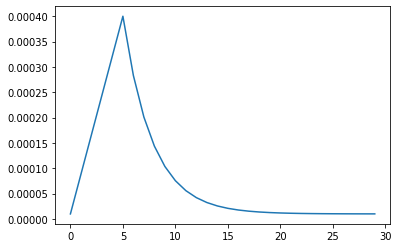

In [11]:
# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .7

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))



### Visualisation Helper Fuctions

In [12]:
def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    with plt.xkcd():
        if subplot%10==1: # set up the subplots on the first call
            plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
            plt.tight_layout()
        ax = plt.subplot(subplot)
        ax.set_facecolor('#F8F8F8')
        ax.plot(training)
        ax.plot(validation)
        ax.set_title('model '+ title)
        ax.set_ylabel(title)
        #ax.set_ylim(0.28,1.05)
        ax.set_xlabel('epoch')
        ax.legend(['train', 'valid.'])

In [13]:
def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()
    
# Visualize model predictions
def dataset_to_numpy_util(dataset, N):
    dataset = dataset.unbatch().batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;  
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    label = np.argmax(label, axis=-1)
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower_eval(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=14, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):
    subplot=331
    plt.figure(figsize=(13,13))
    for i, image in enumerate(images):
        title, correct = title_from_label_and_target(predictions[i], labels[i])
        subplot = display_one_flower_eval(image, title, subplot, not correct)
        if i >= 8:
            break;
              
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

### Dataset functions

In [27]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)



def data_augment(image, label, seed=2020):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image, seed=seed)
#     image = tf.image.random_flip_up_down(image, seed=seed)
#     image = tf.image.random_brightness(image, 0.1, seed=seed)
    
#     image = tf.image.random_jpeg_quality(image, 85, 100, seed=seed)
#     image = tf.image.resize(image, [530, 530])
#     image = tf.image.random_crop(image, [512, 512], seed=seed)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_train_valid_datasets():
    dataset = load_dataset(TRAINING_FILENAMES + VALIDATION_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return int(np.sum(n))

In [28]:
models = []
histories = []


# Exploring Flower(EDA)<a class="anchor" id="eda"></a>

Heavily borrowed from [dimitreoliveira EDA kernel](https://www.kaggle.com/dimitreoliveira/flower-classification-with-tpus-eda-and-baseline/notebook)

In [29]:
# No of images in dataset
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
STEPS_PER_EPOCH = (NUM_TRAINING_IMAGES + NUM_VALIDATION_IMAGES) // BATCH_SIZE
print('Dataset: {} training images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES+NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

AttributeError: ignored

In [ ]:
def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_training_dataset_preview(ordered=True):
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

# Visualization utility functions
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct


# Visualize model predictions
def dataset_to_numpy_util(dataset, N):
    dataset = dataset.unbatch().batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;  
    return numpy_images, numpy_labels

In [ ]:
train_dataset = get_training_dataset_preview(ordered=True)
y_train = next(iter(train_dataset.unbatch().map(lambda image, label: label).batch(NUM_TRAINING_IMAGES))).numpy()
print('Number of training images %d' % NUM_TRAINING_IMAGES)

Number of training images 16465


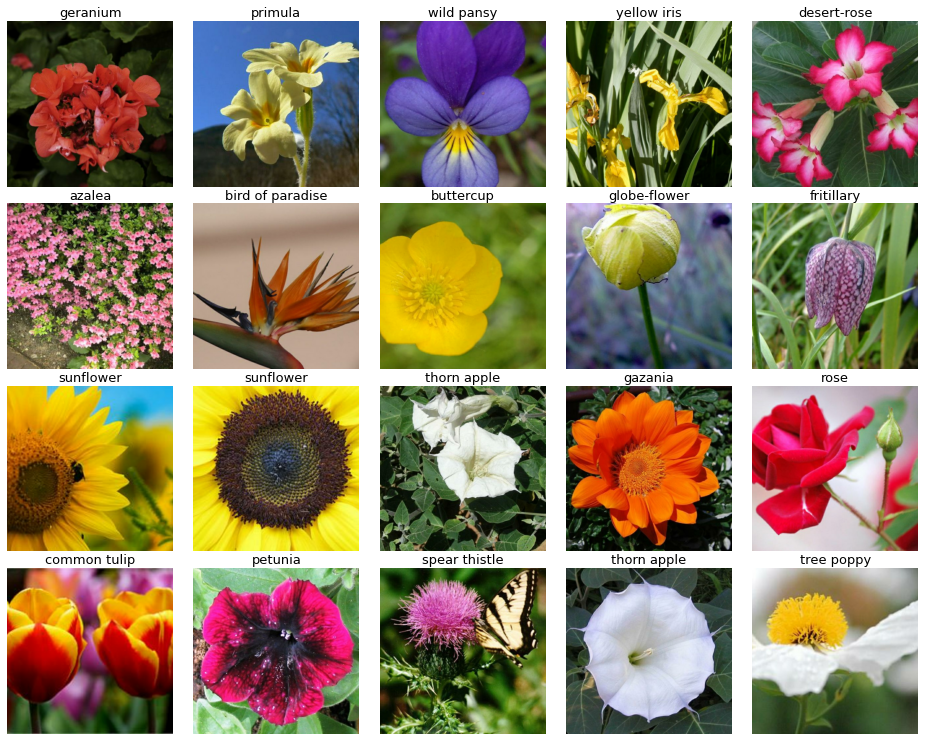

In [ ]:
display_batch_of_images(next(iter(train_dataset.unbatch().batch(20))))

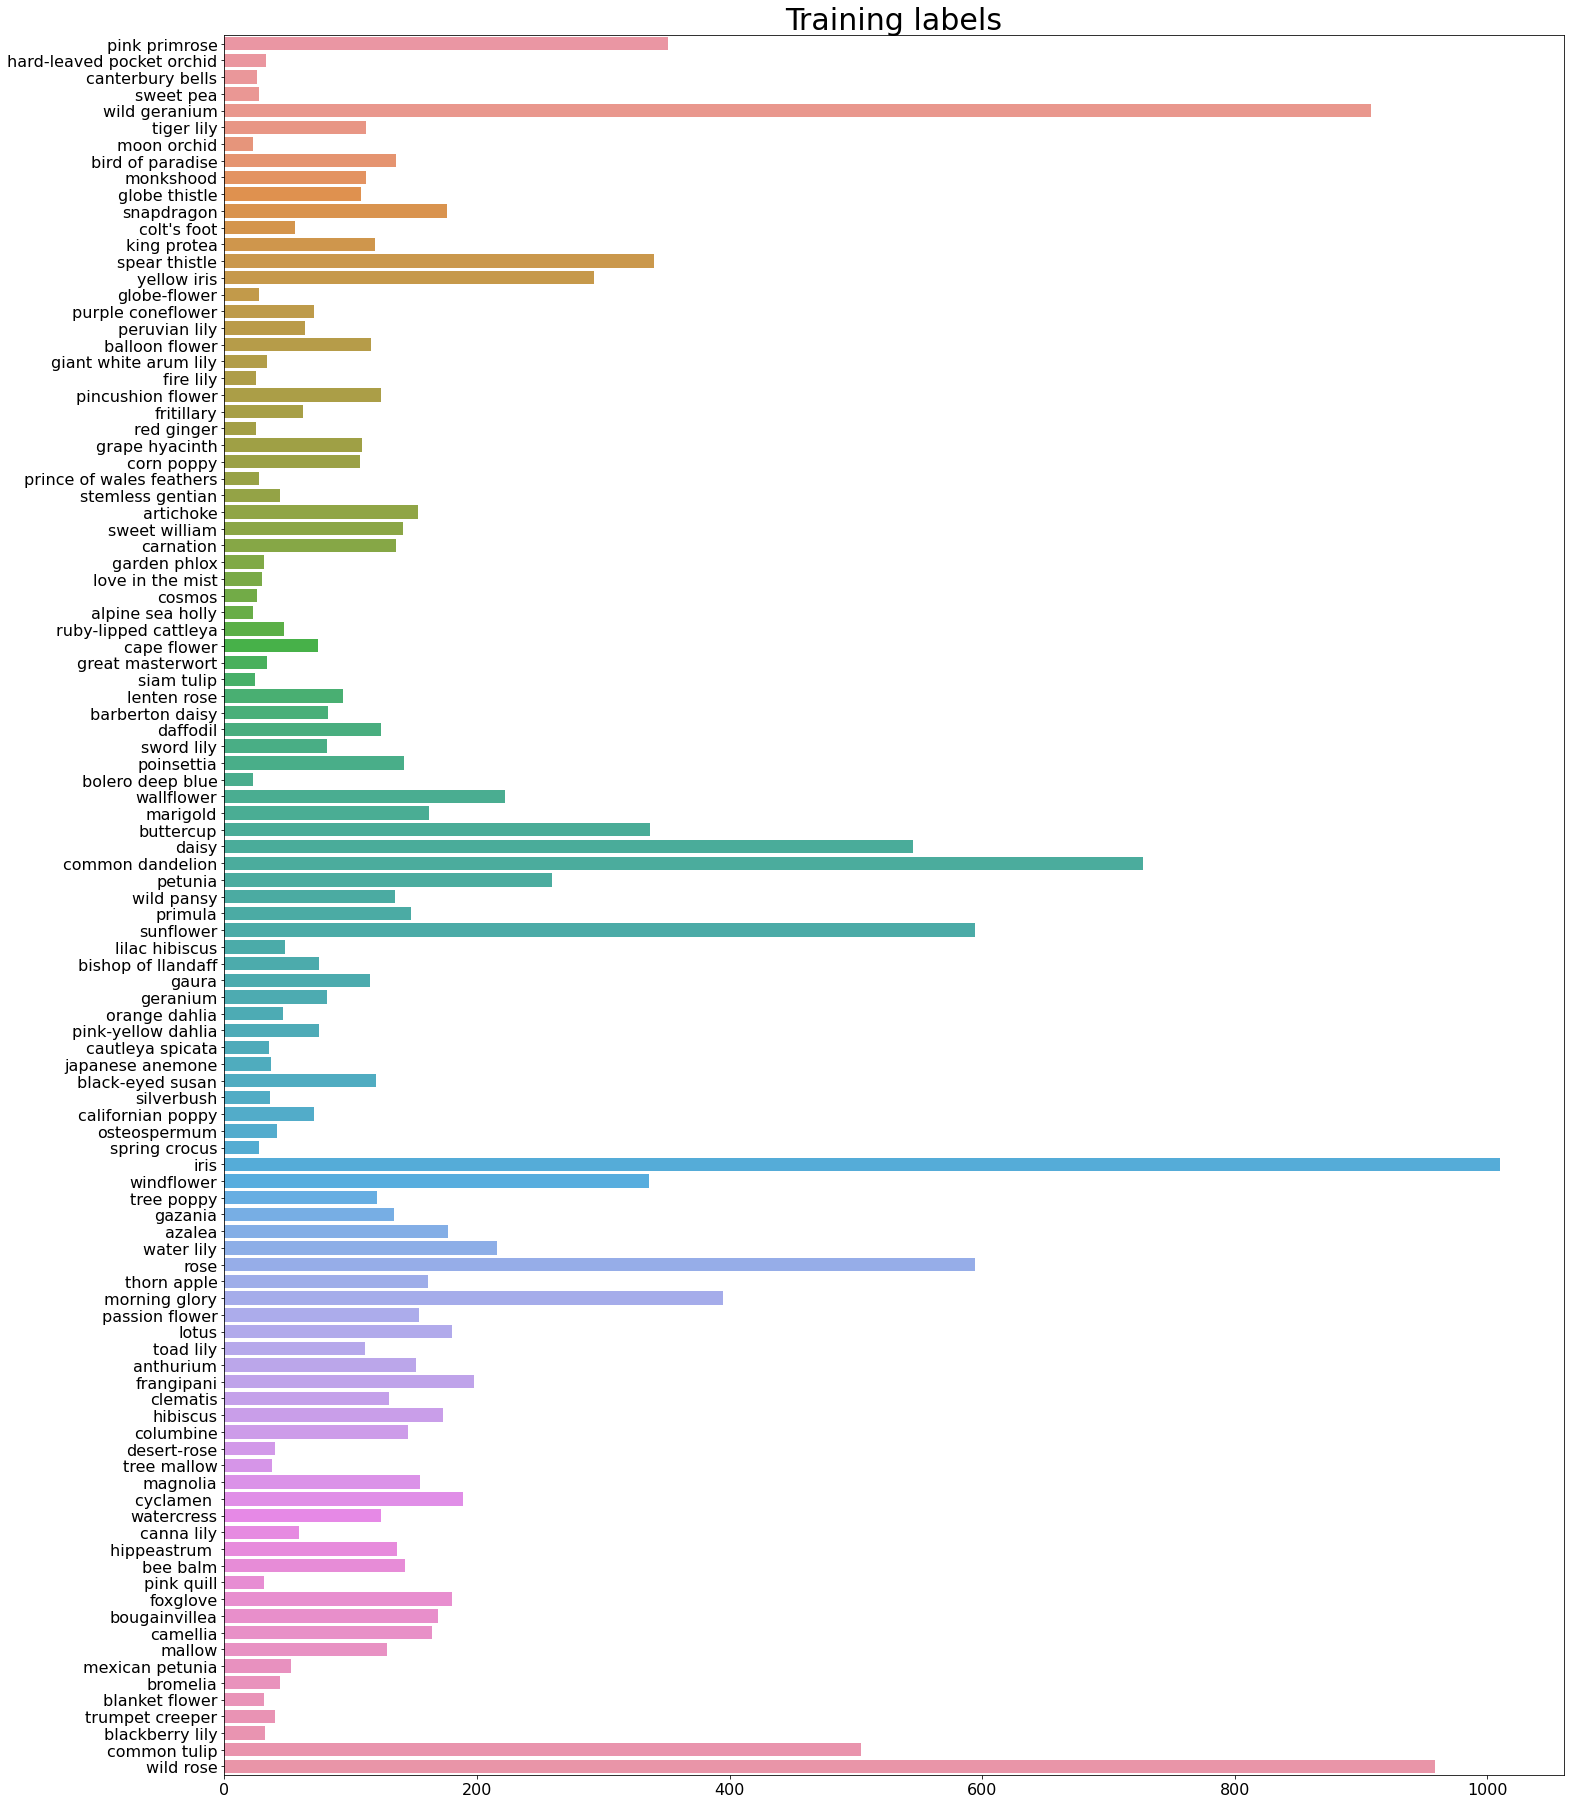

In [ ]:
# Label distribution
train_stack = np.asarray([[label, (y_train == index).sum()] for index, label in enumerate(CLASSES)])

fig, (ax1) = plt.subplots(1, 1, figsize=(24, 32))

ax1 = sns.barplot(x=train_stack[...,1], y=train_stack[...,0], order=CLASSES,ax=ax1)
ax1.set_title('Training labels', fontsize=30)
ax1.tick_params(labelsize=16)


In [ ]:
# peer at test data
test_dataset = get_test_dataset()
test_dataset = test_dataset.unbatch().batch(20)
test_batch = iter(test_dataset)

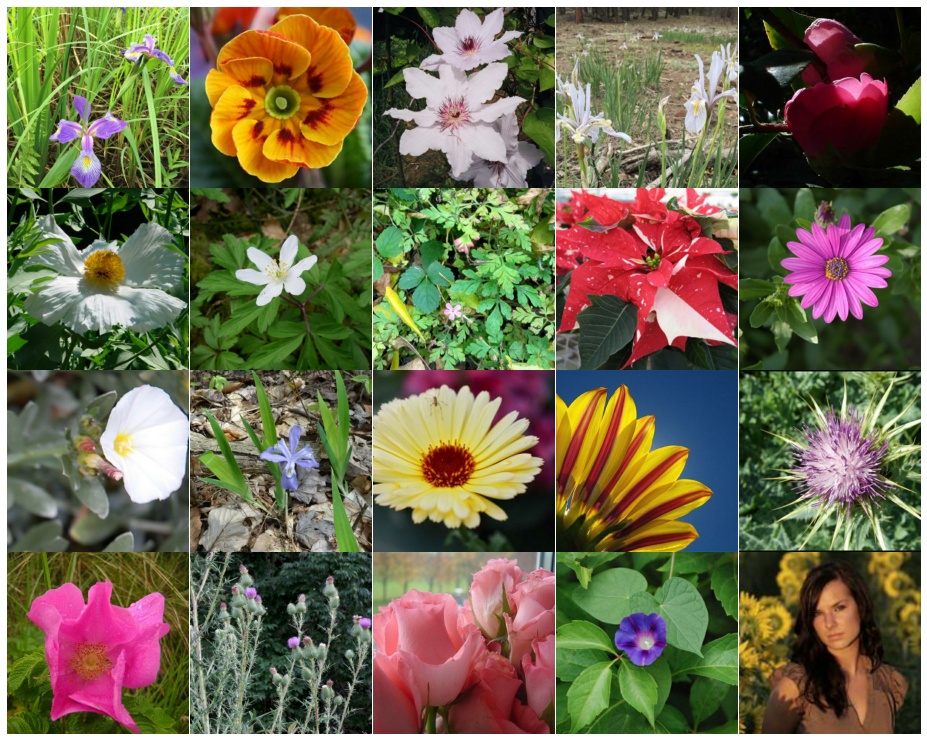

In [ ]:
# run this cell again for next set of images
display_batch_of_images(next(test_batch))

## Augmentations

The following code does random rotations, shear, zoom, and shift using the GPU/TPU. When an image gets moved away from an edge revealing blank space, the blank space is filled by stretching the colors on the original edge. Change the variables in function transform() below to control the desired amount of augmentation. Here's a diagram illustrating the mathematics.

In [ ]:
# def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
#     rotation = math.pi * rotation / 180.
#     shear = math.pi * shear/ 180.
    
#     c1 = tf.math.cos(rotation)
#     c2 = tf.math.sin(rotation)
#     one = tf.constant([1], dtype='float32')
#     zero = tf.constant([0], dtype='float32')
#     rotation_mat = tf.reshape(tf.concat([c1, s1, zero, -s1, c1, zero, \
#                                          zero, zero, one], axis=0), [3,3])
    
#     # shear matrix
#     c2 = tf.math.cos(shear)
#     s2 = tf.math.sin(shear)
#     shear_mat = tf.reshape(tf.concat([one, s2, zero, zero, c2, \
#                                          zero, zero, zero, one], axis=0), [3,3])
    
#     zoom_mat = tf.reshape(tf.concat([one/height_zoom, zero, zero, zero, \
#                                     oneb/width_zoom, zero, zero, zero, one], axis=0), [3,3])
    
#     shift_mat = tf.reshape(tf.concat([one_zero, height_shift, zero, one, width_shift, zero, \
#                                       zero, one], axis=0), [3,3])
    
#     return K.dot(K.dot(rotation_mat, shear_mat), K.dot(zoom_mat, shift_mat))

In [ ]:
# def transform(image, label):
#     DIM = 512
#     XIM = DIM%2
    
#     rot = 15. * tf.random.normal([1], dtype='float32')
#     shr = 5.*tf.random.normal([1], dtype='float32')
#     h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / 1.0
#     w_zoom = 1.0 + tf.random.normal([1], dtype='float32')/1.0
    
#     h_shift = 16. * tf.random.normal([1],dtype='float32') 
#     w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
#     # GET TRANSFORMATION MATRIX
#     m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

#     # LIST DESTINATION PIXEL INDICES
#     x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
#     y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
#     z = tf.ones([DIM*DIM],dtype='int32')
#     idx = tf.stack( [x,y,z] )
    
#     # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
#     idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
#     idx2 = K.cast(idx2,dtype='int32')
#     idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
#     # FIND ORIGIN PIXEL VALUES           
#     idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
#     d = tf.gather_nd(image,tf.transpose(idx3))
        
#     return tf.reshape(d,[DIM,DIM,3]), label

In [ ]:
# row = 3; col = 4;
# all_elements = get_training_dataset(load_dataset(TRAINING_FILENAMES),do_aug=False).unbatch()
# one_element = tf.data.Dataset.from_tensors( next(iter(all_elements)) )
# augmented_element = one_element.repeat().map(transform).batch(row*col)

# for (img,label) in augmented_element:
#     plt.figure(figsize=(15,int(15*row/col)))
#     for j in range(row*col):
#         plt.subplot(row,col,j+1)
#         plt.axis('off')
#         plt.imshow(img[j,])
#     plt.show()
#     break


# What's EfficientNet? <a class="anchor" id="efficentnet"></a>

Most of people in this competition has used Efficient Net for this competiton. I was curious about what's Efficient and why everyone is getting good scores with 
this new Image architecture.

<html>
<body>

<p><font size="4" color="Blue"> Finally I stumbled in this ICML 2019 paper, Efficient Net</font></p>
</body>
</html>
In the paper “EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks”, we propose a novel model scaling method that uses a simple yet highly effective compound coefficient to scale up CNNs in a more structured manner. Unlike conventional approaches that arbitrarily scale network dimensions, such as width, depth and resolution, our method uniformly scales each dimension with a fixed set of scaling coefficients. Powered by this novel scaling method and recent progress on AutoML, we have developed a family of models, called EfficientNets, which superpass state-of-the-art accuracy with up to 10x better efficiency (smaller and faster).

![Screenshot_2020-02-26%20EfficientNet%20Rethinking%20Model%20Scaling%20for%20Convolutional%20Neural%20Networks%20-%20tan19a%20pdf.png](attachment:Screenshot_2020-02-26%20EfficientNet%20Rethinking%20Model%20Scaling%20for%20Convolutional%20Neural%20Networks%20-%20tan19a%20pdf.png)

As the image show's,  EfficientNet tops the current state of the art both in accuracy and in computational efficiency. How did they do this?

## Lesson 1

They learned that CNN’s must be scaled up in multiple dimensions. Scaling CNN’s only in one direction (eg depth only) will result in rapidly deteriorating gains relative to the computational increase needed.Most CNN’s are typically scaled up by adding more layers or deeper . e.g. ResNet18, ResNet34, ResNet152, etc. The numbers represent the total number of blocks (layers) and in general, the more layers the more ‘power’ the CNN has. Going wider is another often used scaling method, and tends to capture finer details and can be easier to train. However, it’s benefits quickly saturate as well.

There are three scaling dimensions of a CNN: depth, width, and resolution. Depth simply means how deep the networks is which is equivalent to the number of layers in it. Width simply means how wide the network is. One measure of width, for example, is the number of channels in a Conv layer whereas Resolution is simply the image resolution that is being passed to a CNN. The figure below(from the paper itself) will give you a clear idea of what scaling means across different dimensions. We will discuss these in detail as well.

![Screenshot_2020-02-27%20EfficientNet%20Rethinking%20Model%20Scaling%20for%20Convolutional%20Neural%20Networks.png](attachment:Screenshot_2020-02-27%20EfficientNet%20Rethinking%20Model%20Scaling%20for%20Convolutional%20Neural%20Networks.png)

## Lesson 2: Compound Scaling

In order to scale up efficiently, all dimensions of depth, width and resolution have to be scaled together, and there is an optimal balance for each dimension relative to the others. Intuition says that as the resolution of the images is increased, depth and width of the network should be increased as well. As the depth is increased, larger receptive fields can capture similar features that include more pixels in an image. Also, as the width is increased, more fine-grained features will be captured. To validate this intuition, the authors ran a number of experiments with different scaling values for each dimension. 

These results lead to our second observation: It is critical to balance all dimensions of a network (width, depth, and resolution) during CNNs scaling for getting improved accuracy and efficiency.

The authors discovered that there is a synergy in scaling multiple dimensions together, and after an extensive grid search derived the theoretically optimal formula of “compound scaling” using the following co-efficients: Depth = 1.20, Width = 1.10, Resolution = 1.15

The authors proposed a simple yet very effective scaling technique which uses a compound coefficient ɸ to uniformly scale network width, depth, and resolution in a principled way

![Screenshot_2020-02-27%20EfficientNet%20Rethinking%20Model%20Scaling%20for%20Convolutional%20Neural%20Networks%281%29.png](attachment:Screenshot_2020-02-27%20EfficientNet%20Rethinking%20Model%20Scaling%20for%20Convolutional%20Neural%20Networks%281%29.png)

ɸ is a user-specified coefficient that controls how many resources are available whereas α, β, and γ specify how to assign these resources to network depth, width, and resolution respectively.

In a CNN, Conv layers are the most compute expensive part of the network. Also, FLOPS of a regular convolution op is almost proportional to d, w², r², i.e. doubling the depth will double the FLOPS while doubling width or resolution increases FLOPS almost by four times. Hence, in order to make sure that the total FLOPS don’t exceed 2^ϕ, the constraint applied is that (α * β² * γ²) ≈ 2


## EfficientNet Architecture

The effectiveness of model scaling also relies heavily on the baseline network. So, to further improve performance, we have also developed a new baseline network by performing a neural architecture search using the AutoML MNAS framework, which optimizes both accuracy and efficiency (FLOPS). The resulting architecture uses mobile inverted bottleneck convolution (MBConv), similar to MobileNetV2 and MnasNet, but is slightly larger due to an increased FLOP budget. We then scale up the baseline network to obtain a family of models, called EfficientNets. 

The MBConv block is nothing fancy but an Inverted Residual Block (used in MobileNetV2) with a Squeeze and Excite block injected sometimes.

Now we have the base network, we can search for optimal values for our scaling parameters. If you revisit the equation, you will quickly realize that we have a total of four parameters to search for: α, β, γ, and ϕ. In order to make the search space smaller and making the search operation less costly, the search for these parameters can be completed in two steps.

- Fix ϕ =1, assuming that twice more resources are available, and do a small grid search for α, β, and γ. For baseline network B0, it turned out the optimal values are α =1.2, β = 1.1, and γ = 1.15 such that α * β² * γ² ≈ 2
- Now fix α, β, and γ as constants (with values found in above step) and experiment with different values of ϕ. The different values of ϕ produce EfficientNets B1-B7.



The effectiveness of model scaling also relies heavily on the baseline network. So, to further improve performance, we have also developed a new baseline network by performing a neural architecture search using the AutoML MNAS framework, which optimizes both accuracy and efficiency (FLOPS). The resulting architecture uses mobile inverted bottleneck convolution (MBConv), similar to MobileNetV2 and MnasNet, but is slightly larger due to an increased FLOP budget. We then scale up the baseline network to obtain a family of models, called EfficientNets. 

![Screenshot_2020-02-27%20EfficientNet%20Improving%20Accuracy%20and%20Efficiency%20through%20AutoML%20and%20Model%20Scaling.png](attachment:Screenshot_2020-02-27%20EfficientNet%20Improving%20Accuracy%20and%20Efficiency%20through%20AutoML%20and%20Model%20Scaling.png)

In [ ]:
# Need this line so Google will recite some incantations
# for Turing to magically load the model onto the TPU
with strategy.scope():
    enet = efn.EfficientNetB7(
        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
        weights='imagenet',
        include_top=False
    )
    
    enet.trainable = True
    model1 = tf.keras.Sequential([
        enet,
        tf.keras.layers.GlobalMaxPooling2D(name="Layer1"),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
        
# METRICS = ['TruePositives','FalsePositives', 'FalseNegatives']
model1.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss = 'sparse_categorical_crossentropy',
    metrics=['categorical_accuracy']
)

model1.summary()

models.append(model1)

258441216/258434480 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 16, 16, 2560)      64097680  
_________________________________________________________________
Layer1 (GlobalMaxPooling2D)  (None, 2560)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               266344    
Total params: 64,364,024
Trainable params: 64,053,304
Non-trainable params: 310,720
_________________________________________________________________


In [ ]:
# schedule = StepDecay(initAlpha=1e-4, factor=0.25, dropEvery=15)

# callbacks = [LearningRateScheduler(schedule)]

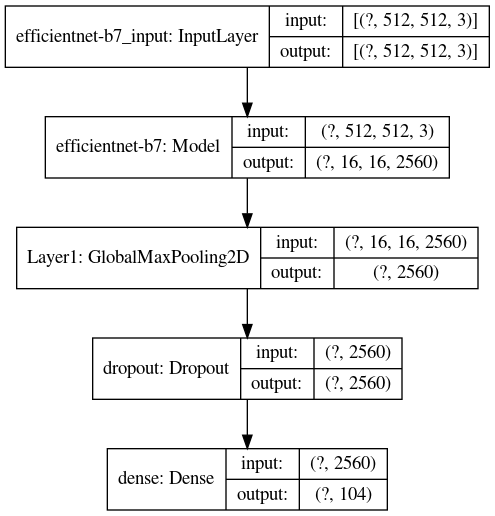

In [ ]:
# Visualising the Model architecture
tf.keras.utils.plot_model(
    model1, to_file='model.png', show_shapes=True, show_layer_names=True,
)


In [ ]:
%%time
Checkpoint=tf.keras.callbacks.ModelCheckpoint(f"Enet_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True,
       save_weights_only=True,mode='max')

train_history1 = model1.fit(
    get_training_dataset(), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[lr_callback, Checkpoint],
)

histories.append(train_history1)




Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/30
78/78 [==============================] - 145s 2s/step - loss: 14.1266 - categorical_accuracy: 0.0193 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/30
78/78 [==============================] - 146s 2s/step - loss: 5.6013 - categorical_accuracy: 0.0224 - lr: 8.8000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/30
78/78 [==============================] - 146s 2s/step - loss: 3.2329 - categorical_accuracy: 0.0270 - lr: 1.6600e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/30
78/78 [==============================] - 146s 2s/step - loss: 2.0050 - categorical_accuracy: 0.0214 - lr: 2.4400e-04

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
Epoch 5/30
78/78 [==============================] - 146s 2s/step - loss: 1.0373 - categorical_accuracy: 0.0213 - lr: 3.2200e-04

Ep

## Training accuracy and loss curves

In [ ]:
def plot_training(H):
	# construct a plot that plots and saves the training history
	with plt.xkcd():
		plt.figure()
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["sparse_categorical_accuracy"], label="train_accuracy")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

KeyError: 'sparse_categorical_accuracy'

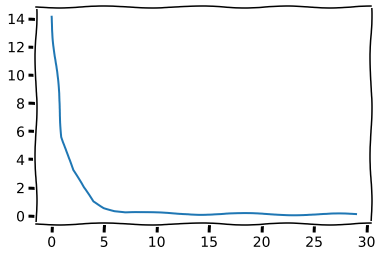

In [ ]:
plot_training(train_history1)

### TPU Utilisation

![Screenshot_2020-03-03%20Introduction%20kernel%20what's%20EfficientNet%20Kaggle.png](attachment:Screenshot_2020-03-03%20Introduction%20kernel%20what's%20EfficientNet%20Kaggle.png)

# DensenetNet model <a class="anchor" id="densenet"></a>

In [ ]:
with strategy.scope():
    densenet = tf.keras.applications.DenseNet201(input_shape=[*IMAGE_SIZE, 3], weights='imagenet', include_top=False)
    densenet.trainable = True
    
    model2 = tf.keras.Sequential([
        densenet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
        
model2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model2.summary()

74842112/74836368 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 16, 16, 1920)      18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 104)               199784    
Total params: 18,521,768
Trainable params: 18,292,712
Non-trainable params: 229,056
_________________________________________________________________


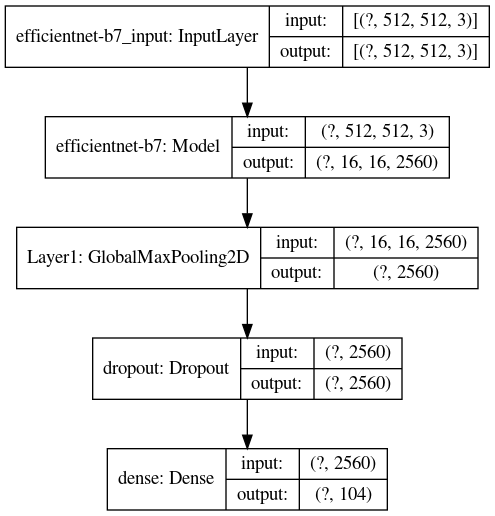

In [ ]:
# Visualising the Model architecture
tf.keras.utils.plot_model(
    model1, to_file='model.png', show_shapes=True, show_layer_names=True,
)

In [ ]:
%%time
Checkpoint=tf.keras.callbacks.ModelCheckpoint(f"Dnet_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True,
       save_weights_only=True,mode='max')
train_history2 = model2.fit(get_training_dataset(), 
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=EPOCHS, 
                    callbacks = [lr_callback, Checkpoint])

histories.append(train_history2)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/30
78/78 [==============================] - 67s 864ms/step - sparse_categorical_accuracy: 0.1455 - loss: 4.1064 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/30
78/78 [==============================] - 68s 868ms/step - sparse_categorical_accuracy: 0.6614 - loss: 1.6497 - lr: 8.8000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/30
78/78 [==============================] - 68s 868ms/step - sparse_categorical_accuracy: 0.8969 - loss: 0.5308 - lr: 1.6600e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/30
78/78 [==============================] - 68s 867ms/step - sparse_categorical_accuracy: 0.9529 - loss: 0.2427 - lr: 2.4400e-04

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
Epoch 5/30
78/78 [==============================] - 68s 868ms/step - sparse_categorical_accuracy

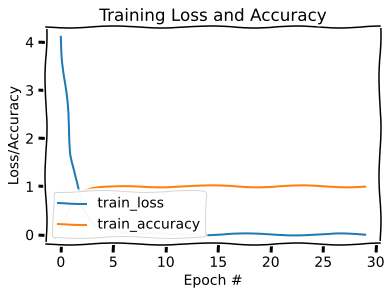

In [ ]:
plot_training(train_history2)

## Submitting Model Predicions <a class="tpu" id="submit"></a>

Ensembling tricks and TTA borrowed from [notebook](https://www.kaggle.com/atamazian/flower-classification-ensemble-effnet-densenet).

## Find best alpha

In [ ]:
if not SKIP_VALIDATION:
    cmdataset = get_validation_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
    images_ds = cmdataset.map(lambda image, label: image)
    labels_ds = cmdataset.map(lambda image, label: label).unbatch()
    cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch
    m1 = model1.predict(images_ds)
    m2 = model2.predict(images_ds)
    scores = []
    for alpha in np.linspace(0,1,100):
        cm_probabilities = alpha*m1+(1-alpha)*m2
        cm_predictions = np.argmax(cm_probabilities, axis=-1)
        scores.append(f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro'))

    best_alpha = np.argmax(scores)/100
else:
    best_alpha = 0.51  # change to value calculated with SKIP_VALIDATION=False
    
print('Best alpha: ' + str(best_alpha))

Best alpha: 0.51


## Confusion Matrix

In [ ]:
if not SKIP_VALIDATION:
    cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
    score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    #cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
    display_confusion_matrix(cmat, score, precision, recall)
    print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

## Test time augmentation(TTA)

In [ ]:
def predict_tta(model, n_iter):
    probs  = []
    for i in range(n_iter):
        test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.
        test_images_ds = test_ds.map(lambda image, idnum: image)
        probs.append(model.predict(test_images_ds,verbose=0))
        
    return probs

In [ ]:
test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.

print('Calculating predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probs1 = np.mean(predict_tta(model1, TTA_NUM), axis=0)
probs2 = np.mean(predict_tta(model2, TTA_NUM), axis=0)
probabilities = best_alpha*probs1 + (1-best_alpha)*probs2
predictions = np.argmax(probabilities, axis=-1)

print('Generating submission file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')


Calculating predictions...
Generating submission file...


[submission](submission.csv)

In [ ]:
predictions

array([ 67,  28,  83, ..., 103, 102,  62])

### References

- https://codelabs.developers.google.com/codelabs/keras-flowers-tpu/#0
- https://arxiv.org/abs/1905.11946
- https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html
- https://medium.com/@lessw/efficientnet-from-google-optimally-scaling-cnn-model-architectures-with-compound-scaling-e094d84d19d4
- https://medium.com/@nainaakash012/efficientnet-rethinking-model-scaling-for-convolutional-neural-networks-92941c5bfb95
- https://www.kaggle.com/mmmarchetti/flowers-on-tpu-ii